# PCA Model Task

### 1) Data Preparation

Importing packages

In [110]:
import datetime
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import sys
import string
from collections import Counter
from nltk import ngrams
import itertools
import random
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.datasets import make_classification  
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import fbeta_score

##### Reading the data, converting the time to timestamp and indexing the date to use it as a time series

In [111]:
#Data Paths
DATA_PATH = sys.path[0]+"\\data\\"
filename_train1="BATADAL_dataset03.csv"
filename_train2="BATADAL_dataset04.csv"
filename_test="BATADAL_test_dataset.csv"

#Reading the data
dftrain1  = pd.read_csv(DATA_PATH + filename_train1)
dftrain2  = pd.read_csv(DATA_PATH + filename_train2)
dftest  = pd.read_csv(DATA_PATH + filename_test)

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftest.DATETIME = dftest.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))

# Choosing 0 if not an anomaly and 1 if anomaly
dftrain2[' ATT_FLAG']=dftrain2[' ATT_FLAG'].apply(lambda x: 0 if x==-999 else x)

# Indexing
dftrain1=dftrain1.set_index('DATETIME')
dftrain2=dftrain2.set_index('DATETIME')
dftest=dftest.set_index('DATETIME')

#dftrain1.shift(1)

##### Dropping variables that are not meant to be used in for prediction (levers).

In [112]:
dftrain1=dftrain1.drop(['S_PU1','S_PU2','S_PU3','S_PU4','S_PU5','S_PU6','S_PU7','S_PU8','S_PU9','S_PU10','S_PU11','S_V2'],axis=1)
dftrain2=dftrain2.drop([' S_PU1',' S_PU2',' S_PU3',' S_PU4',' S_PU5',' S_PU6',' S_PU7',' S_PU8', ' S_PU9',' S_PU10',' S_PU11',' S_V2'],axis=1)
dftest=dftest.drop(['S_PU1','S_PU2','S_PU3','S_PU4','S_PU5','S_PU6','S_PU7','S_PU8','S_PU9','S_PU10','S_PU11','S_V2'],axis=1)

##### Labling the attacks on dftrain2 according to the information below

###### For L_T7
13/09/2016 23 - 16/09/2016 00 |
26/09/2016 11 - 27/09/2016 10
###### For F_PU10 and F_PU11
26/09/2016 11 - 27/09/2016 10
###### For L_T1
09/10/2016 9 - 11/10/2016 20 |
29/10/2016 19 - 02/11/2016 16 |
14/12/2016 15 - 19/12/2016 04
###### For F_PU1 and F_PU2
29/10/2016 19 - 02/11/2016 16 |
14/12/2016 15 - 19/12/2016 04
###### For L_T4
26/11/2016 17 - 29/11/2016 04

In [27]:
#L_T7
dftrain2_L_T7=dftrain2.loc[:,[' L_T7',' ATT_FLAG']]
dftrain2_L_T7.loc[:,' ATT_FLAG']=0
dftrain2_L_T7.loc['2016-09-13 23':'2016-09-16 00',' ATT_FLAG']=1
dftrain2_L_T7.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1
#F_PU10 and F_PU11
dftrain2_F_PU10=dftrain2.loc[:,[' F_PU10',' ATT_FLAG']]
dftrain2_F_PU10.loc[:,' ATT_FLAG']=0
dftrain2_F_PU10.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1

dftrain2_F_PU11=dftrain2.loc[:,[' F_PU11',' ATT_FLAG']]
dftrain2_F_PU11.loc[:,' ATT_FLAG']=0
dftrain2_F_PU11.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1
#L_T1
dftrain2_L_T1=dftrain2.loc[:,[' L_T1',' ATT_FLAG']]
dftrain2_L_T1.loc[:,' ATT_FLAG']=0
dftrain2_L_T1.loc['2016-10-09 09':'2016-10-11 20',' ATT_FLAG']=1
dftrain2_L_T1.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_L_T1.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1
#F_PU1 and F_PU2
dftrain2_F_PU1=dftrain2.loc[:,[' F_PU1',' ATT_FLAG']]
dftrain2_F_PU1.loc[:,' ATT_FLAG']=0
dftrain2_F_PU1.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_F_PU1.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1

dftrain2_F_PU2=dftrain2.loc[:,[' F_PU2',' ATT_FLAG']]
dftrain2_F_PU2.loc[:,' ATT_FLAG']=0
dftrain2_F_PU2.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_F_PU2.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1
#L_T4
dftrain2_L_T4=dftrain2.loc[:,[' L_T4',' ATT_FLAG']]
dftrain2_L_T4.loc[:,' ATT_FLAG']=0
dftrain2_L_T4.loc['2016-11-26 17':'2016-11-29 04',' ATT_FLAG']=1

#dftrain2[' ATT_FLAG']=dftrain2[' ATT_FLAG'].apply(lambda x: 0 if x==-999 else x)

#### Labling the attacks on dftest according to the batadal dataset

In [28]:
dftest[" ATT_FLAG"]=0
dftest.loc['2017-01-16 09':'2017-01-19 06',' ATT_FLAG']=1
dftest.loc['2017-01-30 08':'2017-02-02 00',' ATT_FLAG']=1
dftest.loc['2017-02-09 03':'2017-02-10 09',' ATT_FLAG']=1
dftest.loc['2017-02-12 01':'2017-02-13 07',' ATT_FLAG']=1
dftest.loc['2017-02-24 05':'2017-02-28 08',' ATT_FLAG']=1
dftest.loc['2017-03-10 14':'2017-03-13 21',' ATT_FLAG']=1
dftest.loc['2017-03-25 20':'2017-03-27 01',' ATT_FLAG']=1

##### Normalizing the data

All columns but the last column with the binary classification of anomaly.

In [29]:
#Obs: some values will be converted to float
dftrain1_normalized=dftrain1
dftrain2_normalized=dftrain2
dftest_normalized=dftest
#Dftrain1
dftrain1_normalized.iloc[:,range(0,31)]=preprocessing.scale(dftrain1.iloc[:,range(0,31)])
#Dftrain2
dftrain2_normalized.iloc[:,range(0,31)]=preprocessing.scale(dftrain2.iloc[:,range(0,31)])
#Dftest
dftest_normalized.iloc[:,range(0,31)]=preprocessing.scale(dftest.iloc[:,range(0,31)])

C:\Users\pvbia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
C:\Users\pvbia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.


## 2) PCA Algorithm

_Observation: some of the code used here was derived from the website: This method was derived from: https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html that performed a similar analisis using PCA_

#### Running the PCA for the entire train dataset 1
Running the PCA, reversing the PCA to rebuild the dataset and storing it in a dataframe

In [30]:
#Creating the function
def pca_reverse_trasformation(n_components,random_state,df):
    #Creating PCA model
    pca = PCA(n_components=n_components, whiten=False, random_state=random_state)
    #Applyting PCA transformation to dataset
    df_PCA = pca.fit_transform(df)
    #Saving in a dataframe format
    df_PCA = pd.DataFrame(data=df_PCA, index=df.index)
    #Reversing the PCA
    df_PCA_inverse = pca.inverse_transform(df_PCA)
    #Saving in a dataframe format
    df_PCA_inverse = pd.DataFrame(data=df_PCA_inverse,index=df.index)
    return df_PCA_inverse

#Applying the function
n_components = 10
random_state = 27
df=dftrain1_normalized
dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)

#### Calculating the residuals


In [31]:
def residuals_pca(original_column,pca_column):
    #Creating DF with the selected column from the transformed dataset
    PCA_df=pd.DataFrame(data=pca_column,index=pca_column.index)
    PCA_df.columns = ['transformed']
    PCA_df["original"]=original_column
    #Calculating the residuals
    PCA_df["residuals"]=PCA_df["original"]-PCA_df['transformed']
    return  PCA_df

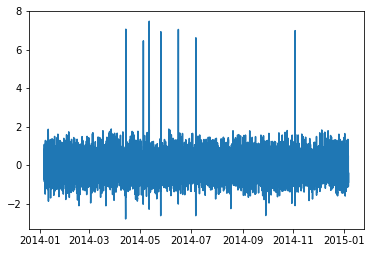

In [32]:
#Testing
original_column=dftrain1_normalized["L_T4"]
pca_column=dftrain1_PCA_inverse[dftrain1_normalized.columns.get_loc("L_T4")]
PCA_L_T4=residuals_pca(original_column,pca_column)
#Plot
plt.plot(PCA_L_T4["residuals"])

#### Analizing why the residuals occured


Ploting the residuals and the normalized original values together

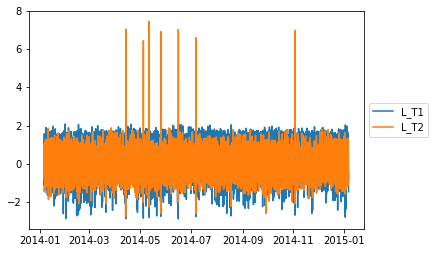

In [33]:
plt.plot(PCA_L_T4["original"], label="normalizd data")
plt.plot(PCA_L_T4["residuals"], label="residuals")
plt.legend(dftrain1_normalized.columns,loc='center left', bbox_to_anchor=(1, 0.5))

Plot the normalized values for which the residual was high for every column

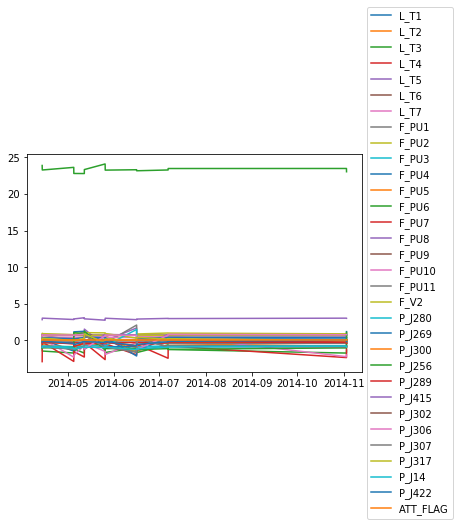

In [34]:
plt.plot(dftrain1_normalized[PCA_L_T4["residuals"]>2])
plt.legend(dftrain1_normalized.columns,loc='center left', bbox_to_anchor=(1, 0.5))

Plot the normalized values for which the residual was normal/low for every column

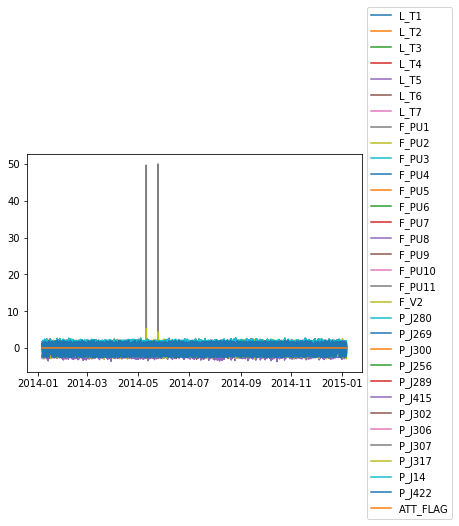

In [35]:
plt.plot(dftrain1_normalized[PCA_L_T4["residuals"]<2])
plt.legend(dftrain1_normalized.columns,loc='center left', bbox_to_anchor=(1, 0.5))

Checking the mean difference for F_PU6, which is the second main difference between the two plots

In [113]:
#df.loc[:,"Score1"].mean()
print("F_PU6 Mean for low/normal residuals: "+ str(dftrain1_normalized.loc[PCA_L_T4["residuals"]<2]["F_PU6"].mean()))
print("F_PU6 Mean for high residuals: "+ str(dftrain1_normalized[PCA_L_T4["residuals"]>2]["F_PU6"].mean()))

F_PU6 Mean for low/normal residuals: 9.765771648672178e-06
F_PU6 Mean for high residuals: -0.042769196939114386


Checking the mean difference for P_J415, which is the main difference between the two plots

In [114]:
#df.loc[:,"Score1"].mean()
print("P_J415 Mean for low/normal residuals: "+ str(dftrain1_normalized.loc[PCA_L_T4["residuals"]<2]["P_J415"].mean()))
print("P_J415 Mean for high residuals: "+ str(dftrain1_normalized[PCA_L_T4["residuals"]>2]["P_J415"].mean()))

P_J415 Mean for low/normal residuals: -8.856189295091127e-05
P_J415 Mean for high residuals: 0.38785681017728046


#### Dropping columns that produced outliers

In [38]:
dftrain1_normalized_nooutlier=dftrain1_normalized.drop(['F_PU6','P_J415'],axis=1)
dftrain2_normalized_nooutlier=dftrain2_normalized.drop([' F_PU6',' P_J415'],axis=1)
dftest_normalized_nooutlier=dftest_normalized.drop(['F_PU6','P_J415'],axis=1)

Testing if the anomalies are gone

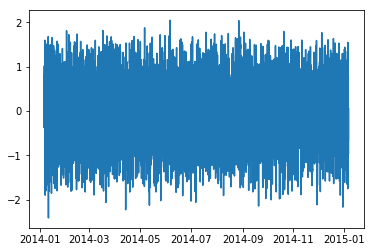

In [39]:
#Applying the PCA
n_components = 10
random_state = 27
df=dftrain1_normalized_nooutlier
dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)

original_column=dftrain1_normalized["L_T4"]
pca_column=dftrain1_PCA_inverse[dftrain1_normalized.columns.get_loc("L_T4")]
PCA_L_T4=residuals_pca(original_column,pca_column)
#Plot
plt.plot(PCA_L_T4["residuals"])

# 3) Predicting Anomalies

### Reverse Anomaly Scores

The transactions that have the largest sum of squared differences will have an error close to zero, while those that have the smallest sum of squared differences will have an error close to one.

In [40]:
def AnomalyScore(originalDF, reducedDF):
    #Calculating the square loss
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    #Changing format
    loss = pd.Series(data=loss,index=originalDF.index)
    #Scaling between 0 and 1
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

### Predicting outliers and calculating performance indicators

In [103]:
def pca_predict(dataset,truelabels,n_pca_components,threshold):
   
    #One random number was picked for the random state
    random_state=27
    ###Generating the model for the data set###
    dataset_PCA_inverse=pca_reverse_trasformation(n_pca_components,random_state,dataset)

    ###Anomaly scores
    AnomalyScoresPCA=AnomalyScore(dataset, dataset_PCA_inverse)
    AnomalyScoresPCA=pd.Series.to_frame(AnomalyScoresPCA)
    AnomalyScoresPCA.columns=["AnomalyScore"]
    
    ###Predicting
    AnomalyScoresPCA['predictions']=AnomalyScoresPCA['AnomalyScore'].apply(lambda x: 1 if x>threshold else 0)
    
    ###Calculating the performance
    cm=confusion_matrix(list(truelabels), list(AnomalyScoresPCA['predictions']))
    if cm.shape==(3,3):
        cm=cm[(0,2),1:]
    #True positive, false positive, false negative and true positive
    tn, fp, fn, tp = cm.ravel()
    #Getting the ratios
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    accuracy=(tp+tn)/(tp+tn+fn+fp)
    #F-score
    F_score=fbeta_score(list(truelabels), list(AnomalyScoresPCA['predictions']), beta=0.5)
    #Probability vector
    performance={"recall":recall,"precision":precision,"Accuracy":accuracy,"F_score":F_score}
    
    return [cm,performance]

Ploting the confusion matrix

In [116]:
def ploting_cm(cm):
    
    #Plot
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix - PCA'); 
    ax.xaxis.set_ticklabels(['normal', 'anomaly']); ax.yaxis.set_ticklabels(['normal', 'anomaly'])

### Predicting anomalies in dftrain2 to optimize parameters

Testing with selected parameters

In [105]:
dataset=dftrain2_normalized_nooutlier.drop([' ATT_FLAG'],axis=1)
truelabels=dftrain2_normalized_nooutlier[' ATT_FLAG']
n_pca_components=10
threshold=0.05
best_PCA_model=pca_predict(dataset,truelabels,n_pca_components,threshold)
print(best_PCA_model)

[array([[3357,  601],
       [ 109,  110]], dtype=int64), {'recall': 0.502283105022831, 'precision': 0.15471167369901548, 'Accuracy': 0.83002154656452, 'F_score': 0.1795625204048319}]


Looping through a parameter space to select the best set of parameters for the dftrain2

In [106]:
#Creating a first model just to initialize the loop
dataset=dftrain2_normalized_nooutlier.drop([' ATT_FLAG'],axis=1)
truelabels=dftrain2_normalized_nooutlier[' ATT_FLAG']
n_pca_components=10
threshold=0.05
parameters=[threshold,n_pca_components]
best_PCA_model=pca_predict(dataset,truelabels,n_pca_components,threshold)
#Looping
n_dimensions=len(dataset.columns)
for t in [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]:
    for p in range(2,n_dimensions-1):
        PCA_model=pca_predict(dataset,truelabels,p,t)
        if PCA_model[1]['F_score']>best_PCA_model[1]['F_score']:
            best_PCA_model=PCA_model
            parameters=[t,p]
#Checking the result
print(best_PCA_model)
print(parameters)

[array([[3922,   36],
       [ 174,   45]], dtype=int64), {'recall': 0.2054794520547945, 'precision': 0.5555555555555556, 'Accuracy': 0.949724682786689, 'F_score': 0.41436464088397784}]
[0.05, 17]


### Detecting anomalies in the test set

{'recall': 0.47174447174447176, 'precision': 0.8347826086956521, 'Accuracy': 0.8788894207754907, 'F_score': 0.7234363225320272}


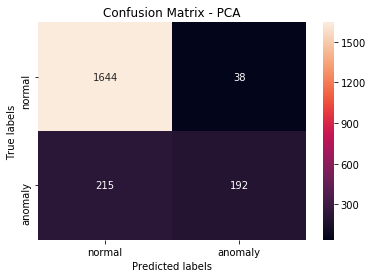

In [117]:
dataset=dftest_normalized_nooutlier.drop([' ATT_FLAG'],axis=1)
truelabels=dftest_normalized_nooutlier[' ATT_FLAG']
n_pca_components=parameters[1]
threshold=parameters[0]
PCA_model_testset=pca_predict(dataset,truelabels,n_pca_components,threshold)
ploting_cm(PCA_model_testset[0])
print(PCA_model_testset[1])